## 딥러닝을 사용한 시계열 데이터 예측 


(클래식 머신러닝과 성능비교, transfer learning  적용하여)


# 목차 

1. 프로젝트 목적 및 진행절차 소개 (데이터, 가설, 평가지표 소개)
2. 기준모델
3. Deep Learning 기법 적용 및 성능 비교 
      
*   모델 구성법 (학습/타겟 데이터 window 생성)
*   모델1.Simple RNN
*   모델2.LSTM
*   모델3.GRU

4. Transfer Learning 적용 및 비교 
*  Sorce Model
*   LSTM (재학습x)
*   LSTM (재학습 1층)
*   LSTM (재학습 2층)

5. 결론 및 한계점




#1. 프로젝트 목적 및 진행절차 소개 (데이터, 가설, 평가지표 소개)


# 1-1) 프로젝트 목적

시계열 데이터 분석을 위해 딥러닝이 머신러닝에 비해 갖는 성능 우위 평가

# 1-2) 진행 절차 

1) 이전에 진행한 classic 머신러닝 ( linear regression ,random forest regressor , XGB boosting emd) 으로 기준모델 생성

2) 딥러닝 (Simple RNN, LSTM, GRU) 적용 후 성능 비교

3) Trasnfer Learning적용 후 성능 비교

# 1-3) 가설


가설1- deep learning 이 좀 더 성능이 좋겠지만, 큰 차이 없을 것이다.

근거- Application of machine learning techniques for supply chain demand forecasting (2008)



가설2 - 도메인이 다르더라도 다른 시계열 데이터로 transfer learning할 시 성능이 조금 항상될 것이다.

근거- computer vision 에서 다른 도메인의 task도 transfer larning 시 성능향상에 기여하는 것을 착안 



# 1-4) 데이터 소개 

데이터: Walmart Weekly Sales Data


데이터 수집 기간: 2010-02-05 to 2012-11-01


변수: 16개 Store, Dept, 공휴일 유무(Super Bowl, Labor Day, Thanksgiving, Christmas), 기온, Markdown, CPI, 실업률, 유가

데이터 사이즈 : 143rows 
(원본데이터 421,570 rows * 17 columns,  동일한 날짜에 store/ dept 별 다른 데이터가 있으나, 프로젝트의 목적은 변수 별이 아닌 시간 별 sales data 예측 이므로 날짜별로 축소)

*데이터 EDA 따로 진행했으며, 해당 데이터의 특성을 잘 나타내 주는 아래 두 자료만 가져왔습니다.
(좌) average weekly sales by per year ( 주별 판매량이 년도별로 비슷한 트렌드를 보여줍니다)
(우) weekly sales 와 다른 변수 간 상관관계(절대값)

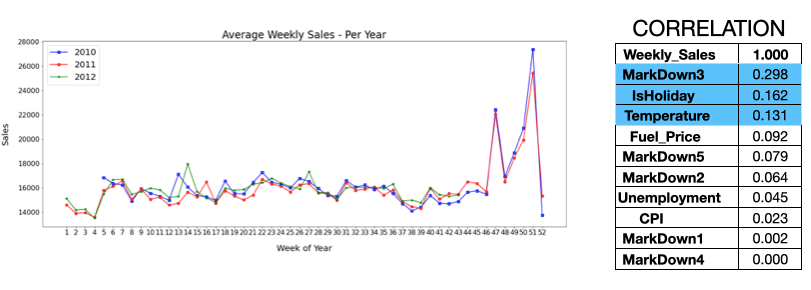

# 1-5) 평가 지표 

주 평가 지표 MAE (Mean Absolute Error) - 예상치와 실제값의 차이 절대값의 평균


선정 이유:공휴일/ 피크시즌의 세일즈가 폭발할 경우 이상치로 잡지 않고, 좀 더 직관적인 평가가 가능하므로 선정


보조 평가지표 MSE

In [ ]:
#라이브러리 

!pip install category_encoders
!pip install finance-datareader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import FinanceDataReader as fdr
import tensorflow as tf

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SimpleRNN, GRU, LSTM, Conv1D, Lambda, Dropout
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError, Huber
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint    

#  2. 기준모델 
XGB Boosting Regressor (mae: 1026.4929 mse: 1518400.5)

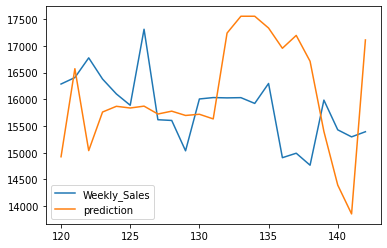




Random Forest Regressor (mae: 1038.08203125 mse: 1806367.25)



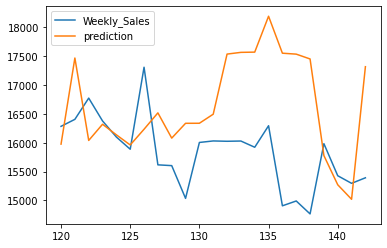


In [ ]:
#구글드라이브 마운트로 데이터 접근 
#cd /content/drive/MyDrive/CodeStates/Section2/dataset/walmart-recruiting-store-sales-forecasting

In [4]:
#local 에서 업로드 
from google.colab import files
uploaded= files.upload()

Saving features_rev.csv to features_rev.csv
Saving train_rev.csv to train_rev.csv


In [74]:
#데이터 불러오기 
train_rev=pd.read_csv("train_rev.csv", index_col="Date")
features_rev=pd.read_csv("features_rev.csv",index_col="Date")
df=train_rev.merge(features_rev,on="Date",how="inner")
cols=df.columns
df=df.fillna(0)
df['IsHoliday']=df['IsHoliday_x'].replace({True:1,False:0})
df=df.drop(["IsHoliday_x","IsHoliday_y"],axis=1)
#train & test 데이터 나누기 
train,test=train_test_split(df,test_size=0.16,shuffle=False)
#x ,y 데이터 분리 
target='Weekly_Sales'
y_train=train[target]
X_train=train.drop(target,axis=1)
y_test=test[target]
X_test=test.drop(target,axis=1)


In [7]:
#xgb boosting regressor
pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBRegressor(max_depth=10)
)

pipe.fit(X_train, y_train);
y_train_pred=pipe.predict(X_train)
y_test_pred=pipe.predict(X_test)

print("훈련데이터")
print("MAE:",mean_absolute_error(y_train,y_train_pred),"MSE:",mean_squared_error(y_train,y_train_pred),"R2:",r2_score(y_train,y_train_pred))

print("테스트데이터")
print("MAE:",mean_absolute_error(y_test,y_test_pred),"MSE:",mean_squared_error(y_test,y_test_pred),"R2:",r2_score(y_test,y_test_pred))

[03:25:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
훈련데이터
MAE: 18.065278496627602 MSE: 974.845499604238 R2: 0.9997362468180416
테스트데이터
MAE: 1026.4927155360426 MSE: 1518400.0522747505 R2: -3.134865092664424


In [10]:
# 예측값 vs 실제값 비교 그래프
def pred_plot(preds):
  actual_pred = pd.DataFrame(columns = ['Weekly_Sales', 'prediction'])
  actual_pred['Weekly_Sales']=df.Weekly_Sales.iloc[120:][0:len(preds)]
  actual_pred['prediction']=preds
  y_true = actual_pred['Weekly_Sales']
  y_pred = actual_pred['prediction']

  print(y_true[:2])
  print(y_pred[:2])
  print("len comp(true vs pred):",len(y_true),len(y_pred))
  mae = MeanAbsoluteError()
  mse = MeanSquaredError()
  result=mae(y_true,y_pred).numpy()
  result2=mse(y_true,y_pred).numpy()
  return print("mae:",result,"mse:",result2,actual_pred.plot())

In [ ]:
# xgb bosst regressor 예측 그래프
pred_plot(y_test_pred)

In [ ]:
# Random Forest Regressor
pipe=make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    MinMaxScaler(),
    RandomForestRegressor(
        random_state=2,n_jobs=-1,max_depth=15,
        n_estimators=30,min_samples_split=10,
        min_samples_leaf=2,max_samples=0.8,max_features=7)
)

pipe.fit(X_train,y_train)
y_pred=pipe.predict(X_train)
y_test_pred=pipe.predict(X_test)


print("훈련데이터")
print("MAE:",mean_absolute_error(y_train,y_train_pred),"MSE:",mean_squared_error(y_train,y_train_pred),"R2:",r2_score(y_train,y_train_pred))

print("테스트데이터")
print("MAE:",mean_absolute_error(y_test,y_test_pred),"MSE:",mean_squared_error(y_test,y_test_pred),"R2:",r2_score(y_test,y_test_pred))


In [ ]:
#random forest regressor 그래프
pred_plot(y_test_pred)

# 3. Deep Learning 기법 적용 및 성능 비교 (RNN, LSTM, GRU)


# 3-1)모델 구성법 (학습/타겟 데이터 window 생성)

In [77]:
def WindowGenerator_normalize(all_data,time_steps,for_periods):
    '''
    all data: 분리 하기 위하는 데이터 (날짜 + weekly sales) 
      data: dataframe with dates and price data
    output:
      X_train, y_train, X_test, y_test :  학습과 테스트는 전체데이터의 16%비율로 분할 (120)
      sc: 스케일러 MinMaxScaler 객체
    '''
    # 학습/ 테스트 셋 생성 (다른 변수 포함없이, x&y모두 weekly sales만 포함)
    ts_train = train_rev.iloc[:120,:1].values
    ts_test  = train_rev.iloc[120:,:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # 데이터 스케일 (매우 중요) , train data만 사용해 transform (매우중요)
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)

    # [시계열 데이터 분석의 핵심] - 몇 time steps데이터를 보고 몇 for_periods 를 예측할지 학습/테스트 데이터 생성
    X_train = []
    y_train = []
    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train_scaled[i-time_steps:i,0])
        y_train.append(ts_train_scaled[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling - 
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    inputs = pd.concat((train_rev["Weekly_Sales"].iloc[:120], train_rev["Weekly_Sales"].iloc[120:]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs  = sc.transform(inputs)

        # Preparing X_test
    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test, sc

In [78]:
X_train, y_train, X_test, sc = WindowGenerator_normalize(train_rev,5,2)

In [ ]:
# X_train, y_train 데이터 확인하기
X_train_see = pd.DataFrame(np.reshape(X_train, (X_train.shape[0],X_train.shape[1])))
y_train_see=pd.DataFrame(y_train)
pd.concat([X_train_see,y_train_see],axis=1)

#3-2) 모델1.Simple RNN
(mae: 489.3875 mse: 381402.8)

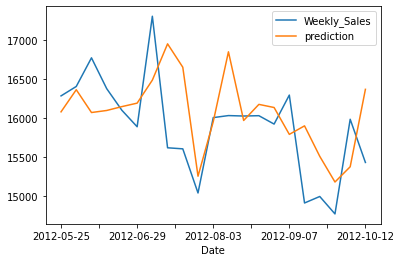


In [22]:
def simple_rnn_model(X_train, y_train, X_test, sc):
    '''
 2층 simple rnn모델 생성
    '''
    # simple rnn모델

    my_rnn_model = Sequential()
    my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    #my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    my_rnn_model.add(SimpleRNN(32))
    my_rnn_model.add(Dense(2)) # 예측 2값

    my_rnn_model.compile(optimizer='rmsprop', loss='mean_absolute_error')

    # fit the RNN model
    my_rnn_model.fit(X_train, y_train, epochs=1000, verbose=0)

    # predictions
    rnn_predictions = my_rnn_model.predict(X_test)
    rnn_predictions = sc.inverse_transform(rnn_predictions)

    return my_rnn_model, rnn_predictions

In [ ]:
#simple rnn

my_rnn_model, rnn_predictions_2 = simple_rnn_model(X_train, y_train, X_test, sc)
pred_plot(rnn_predictions_2)

In [ ]:
my_rnn_model.summary()

# 3-2) 모델2.LSTM 

(mae: 519.5237 mse: 359547.75)

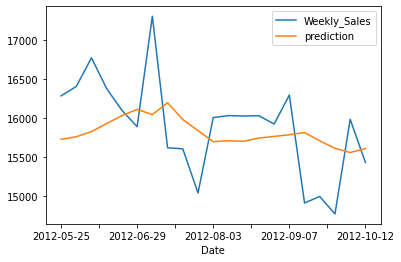

In [ ]:
#LSTM (simple rnn과 동일한 optimizer)
def LSTM_model(X_train, y_train, X_test, sc):
    # LSTM구조 
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='relu'))
    #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=50, activation='tanh'))
    my_LSTM_model.add(Dense(units=2))

    # Compiling
    my_LSTM_model.compile(optimizer='rmsprop', loss='mean_absolute_error')
    # Fitting 
    my_LSTM_model.fit(X_train,y_train,epochs=500, verbose=0)
    my_LSTM_model.summary()

    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction, my_LSTM_model.summary

my_LSTM_model, LSTM_prediction, my_LSTM_model.summary = LSTM_model(X_train, y_train, X_test, sc)
pred_plot(LSTM_prediction)


In [ ]:
#LSTM (complile 옵션 다르게 적용 ) - 성능은 좋으나, 예측 값이 일관 
def LSTM_model(X_train, y_train, X_test, sc):
    # LSTM 층
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='relu'))
    #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=50, activation='tanh'))
    my_LSTM_model.add(Dense(units=2))
    # Compiling
    my_LSTM_model.compile(optimizer=SGD(lr=0.01,  momentum=0.9, nesterov=False),loss='mean_absolute_error')#decay=1e-7,#
    # Fitting 
    my_LSTM_model.fit(X_train,y_train,epochs=50, verbose=0)

    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction

my_LSTM_model, LSTM_prediction = LSTM_model(X_train, y_train, X_test, sc)
LSTM_prediction[1:10]
pred_plot(LSTM_prediction)

In [ ]:
def LSTM_model_regularization(X_train, y_train, X_test, sc): #simple rnn과 동일한 optimizer
 
    # 모델
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, activation='tanh'))
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=50, activation='tanh'))
    my_LSTM_model.add(Dropout(0.2))
    my_LSTM_model.add(Dense(units=2))

    # Compiling
    my_LSTM_model.compile(optimizer='rmsprop', loss='mean_absolute_error')
    # Fitting 
    my_LSTM_model.fit(X_train,y_train,epochs=500, verbose=0)


    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction

my_LSTM_model, LSTM_prediction = LSTM_model_regularization(X_train, y_train, X_test, sc)
LSTM_prediction[1:10]
pred_plot(LSTM_prediction)

In [ ]:
my_LSTM_model.summary()

# 3-2) 모델3.GRU

(mae: 478.45493 mse: 335184.06)

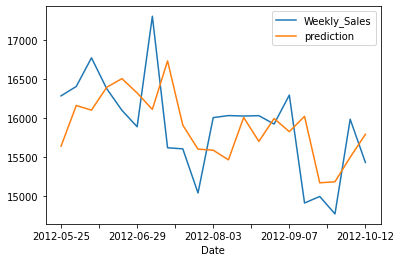



In [ ]:
#GRU (시계열 GRU 모델 추천 hyper parameter적용 )
def GRU_model(X_train, y_train, X_test, sc):

    # 모델
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units = 50, 
                         return_sequences = True, 
                         input_shape = (X_train.shape[1],1), 
                         activation = 'tanh'))
    my_GRU_model.add(GRU(units = 50, 
                         activation = 'tanh'))
    my_GRU_model.add(Dense(units = 2))
    
    # Compiling  
    my_GRU_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False), 
                         loss = 'mean_absolute_error')
    
    # Fitting
    my_GRU_model.fit(X_train, y_train, epochs = 50, verbose = 0)
    
    GRU_prediction = my_GRU_model.predict(X_test)
    GRU_prediction = sc.inverse_transform(GRU_prediction)
    
    return my_GRU_model, GRU_prediction 

my_GRU_model, GRU_prediction = GRU_model(X_train, y_train, X_test, sc)
GRU_prediction[1:10]
pred_plot(GRU_prediction)

In [ ]:
#GRU (simple rnn 에 적용한 compiling 적용)
def GRU_model(X_train, y_train, X_test, sc):

    # GRU Architecture 
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units = 50, 
                         return_sequences = True, 
                         input_shape = (X_train.shape[1],1), 
                         activation = 'tanh'))
    my_GRU_model.add(GRU(units = 50, 
                         activation = 'tanh'))
    my_GRU_model.add(Dense(units = 2))
    
    # Compiling
    my_GRU_model.compile(optimizer='rmsprop', loss='mean_absolute_error')
    # Fitting to the training set
    my_GRU_model.fit(X_train,y_train,epochs=500, verbose=0)

    # Fitting to the trainig set 
    my_GRU_model.fit(X_train, y_train, epochs = 50, verbose = 0)
    
    GRU_prediction = my_GRU_model.predict(X_test)
    GRU_prediction = sc.inverse_transform(GRU_prediction)
    
    return my_GRU_model, GRU_prediction 

my_GRU_model, GRU_prediction = GRU_model(X_train, y_train, X_test, sc)
GRU_prediction[1:10]
pred_plot(GRU_prediction)

In [ ]:
my_GRU_model.summary()

주식 데이터 모델로 transfer learning 시도 







#    4. Transfer Learning 적용 및 비교

비교적 개수가 많은 시계열 데이터인 주식 정보를 sorce domain으로 사용(종목: 삼성전자, 수집기간: 1990-2020, 개수:6,000개 ),

 주식 데이터를 학습한 model 을 sales forecasting에 전이학습 시도 했습니다.

# 4-1) Source model (삼성전자 가격 예상 모델)

In [35]:
# 삼성전자 주식코드: 005930
STOCK_CODE = '005930'

In [126]:
#주식 데이터 가져 오기 
stock = fdr.DataReader(STOCK_CODE)
stock['Year'] = stock.index.year
stock['Month'] = stock.index.month
stock['Day'] = stock.index.day

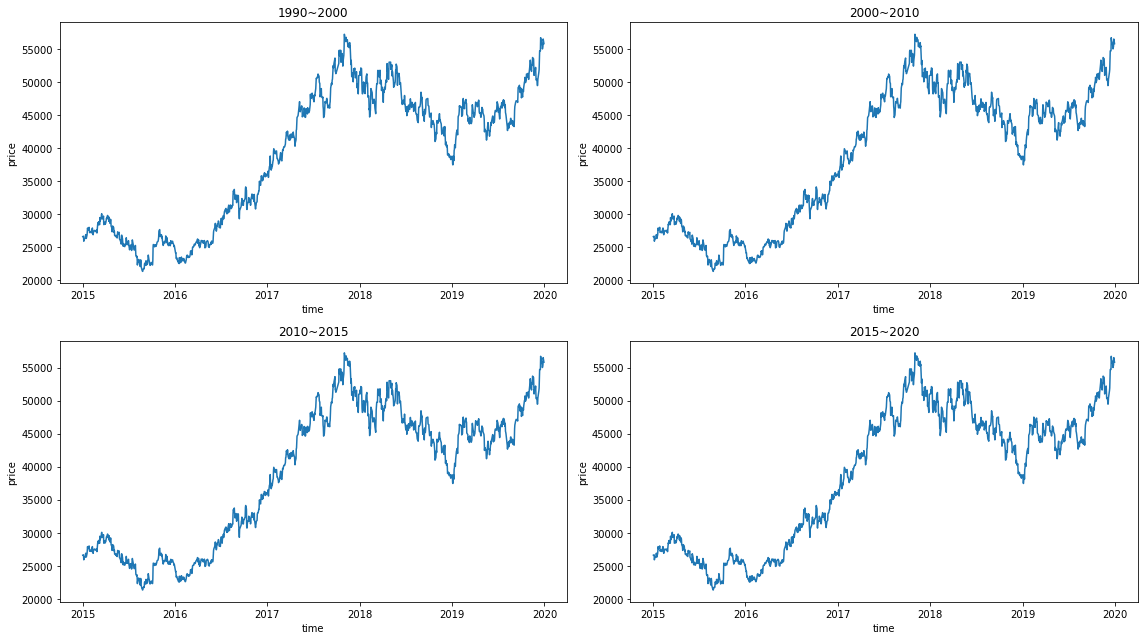

In [59]:
#데이터 살펴보기 (df2)
time_steps = [['1990', '2000'], 
              ['2000', '2010'], 
              ['2010', '2015'], 
              ['2015', '2020']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
for i in range(4):
    ax = axes[i//2, i%2]
    df2 = stock.loc[(stock.index > time_steps[i][0]) & (stock.index < time_steps[i][1])]
    sns.lineplot(y=df['Close'], x=df.index, ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

In [128]:
#데이터 스케일링
scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(stock[scale_cols])
df2 = pd.DataFrame(scaled, columns=scale_cols)
# train, test분할
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(df2.drop('Close', 1), df2['Close'], test_size=0.2, random_state=0, shuffle=False)

In [129]:
#TensroFlow Dataset을 활용한 시퀀스 데이터셋 구성
def windowed_dataset(series, window_size, batch_size, shuffle):
  """
    window size=3이면 3일 주가 보고, 다음날 예측
    stride - window를 한칸식 건너 뛰면서 묶겠다. 
    drop_remainder - window생성시 남는 데이터를 어떻게 처리할지 -> 크기 일치시키기 위해 true로 설정
    shuffle(buffer_size)데이터 셋 섞기 ,30000개 데이터에서 버퍼사이즈가 1000이라면 0~999인덱스 사이즈 중 랜덤 추출
    prefetch -미리 데이터를 fetch. (병렬 처리 하기 때문에 학습 속도 개선)
    prefetch(1)시 다음 데이터 만들어, 1번 학습 시  병렬 적으로 뒤에 배치를 만듬 , 미리 만들어서 바로 학습
    """
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series) # numpy array(series)를 넣으면 data set class 로 변경,  dataset이 구현가능한 함수 사용 위해
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True) #window set을 짜를 때는 size , size+1 (y)까지 자름
    
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  if shuffle:
      ds = ds.shuffle(1000)
  ds = ds.map(lambda w: (w[:-1], w[-1])) #(x(window 사이즈 개수),y)
  return ds.batch(batch_size).prefetch(1)

In [130]:
#hyper parameter - 5일치 학습
WINDOW_SIZE=5
BATCH_SIZE=32

In [131]:
# trian_data_s는 학습용 데이터셋, test_data_s는 검증용 데이터셋 
train_data_s = windowed_dataset(y_train_s, WINDOW_SIZE, BATCH_SIZE, False)
test_data_s = windowed_dataset(y_test_s, WINDOW_SIZE, BATCH_SIZE, False)

In [132]:
# 데이터 셋 잘 구성 됐는지 확인
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data_s.take(1): #take 1- 한 개의 batch 만
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 5, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


In [ ]:
#삼성전자 시계열 예측 (original) 
model = Sequential([
#     1차원 feature map 생성
     Conv1D(filters=32, kernel_size=5,
            padding="causal",
            activation="relu",input_shape=[WINDOW_SIZE, 1]),
     Dense(16, activation="relu"),
#     LSTM
     Dense(16, activation="relu"),
     LSTM(16, activation='tanh'),
     Dense(16, activation="relu"),
     Dense(1),
 ])
 # Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용
loss = Huber()
optimizer = Adam(0.01)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)
history = model.fit(train_data_s, 
                    validation_data=(test_data_s), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

pred= model.predict(test_data_s)

model.summary()

In [145]:
model.load_weights(filename)
pred = model.predict(test_data_s)

In [ ]:
#예측 데이터 시각화
#지표
mae=MeanAbsoluteError()
mse=MeanSquaredError()
result=mae(y_test_s[5:],pred).numpy()
result2=mse(y_test_s[5:],pred).numpy()
print("mae:",result,"mse",result2)

#그래프
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test_s)[5:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [57]:
#model save
if os.path.isfile('models/stock_model.h5') is False:
  model.save('models/stock_model.h5')

# 4-2) 수요예측 LSTM 모델에 적용 (재학습x)

(mae: 517.8713 mse: 398747.2)

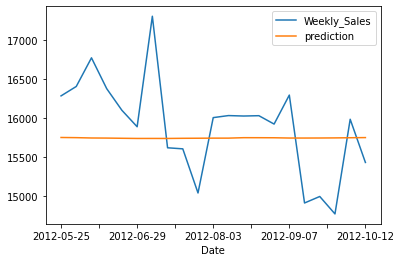

Date
2012-05-25    16284.414590
2012-06-01    16405.589439
Name: Weekly_Sales, dtype: float64
Date
2012-05-25    15748.984375
2012-06-01    15746.903320
Name: prediction, dtype: float32
len comp(true vs pred): 21 21
mae: 517.8713 mse: 398747.2 AxesSubplot(0.125,0.125;0.775x0.755)


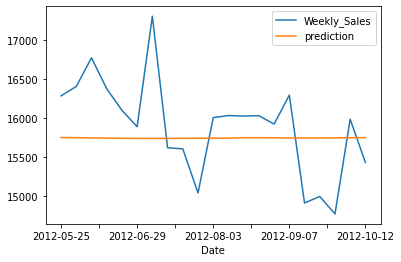

In [80]:
#LSTM (stock original optimizer)
def new_model_fun(X_train, y_train, X_test, sc):

    new_model=load_model('models/stock_model.h5')

    new_model.trainable=False
    
    # Compiling (stock original)
    new_model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

    # Fitting to the training set
    new_model.fit(X_train,y_train,epochs=500, verbose=0)

    LSTM_prediction = new_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return new_model, LSTM_prediction

new_model_fun(X_train, y_train, X_test, sc)
pred_plot(LSTM_prediction)

In [ ]:
##stock original

model = Sequential([
#      1차원 feature map 생성
     Conv1D(filters=32, kernel_size=5,
            padding="causal",
            activation="relu",input_shape=[WINDOW_SIZE, 1]),
#LSTM(50, activation='tanh',return_sequences=True),
#LSTM(50, activation='tanh',return_sequences=True),     
#LSTM(50, activation='tanh'),
#Dense(2)])
#     LSTM
     Dense(16, activation="relu"),
     LSTM(16, activation='tanh'),
     Dense(16, activation="relu"),
     Dense(1),
 ])

# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.01)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

history = model.fit(train_data_s, 
                    validation_data=(test_data_s), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
    144/Unknown - 4s 7ms/step - loss: 6.6138e-05 - mse: 1.3228e-04
Epoch 00001: val_loss improved from inf to 0.00069, saving model to tmp/ckeckpointer.ckpt
150/150 [==============================] - 5s 13ms/step - loss: 6.4791e-05 - mse: 1.2958e-04 - val_loss: 6.8597e-04 - val_mse: 0.0014
Epoch 2/50
143/150 [===========================>..] - ETA: 0s - loss: 1.9473e-05 - mse: 3.8946e-05
Epoch 00002: val_loss improved from 0.00069 to 0.00057, saving model to tmp/ckeckpointer.ckpt
150/150 [==============================] - 1s 9ms/step - loss: 2.1458e-05 - mse: 4.2915e-05 - val_loss: 5.6540e-04 - val_mse: 0.0011
Epoch 3/50
150/150 [==============================] - ETA: 0s - loss: 1.7495e-05 - mse: 3.4989e-05
Epoch 00003: val_loss did not improve from 0.00057
150/150 [==============================] - 1s 8ms/step - loss: 1.7495e-05 - mse: 3.4989e-05 - val_loss: 6.0141e-04 - val_mse: 0.0012
Epoch 4/50
148/150 [============================>.] - ETA: 0s - loss: 2.7355e-05 - mse: 5

Date
2012-05-25    16284.414590
2012-06-01    16405.589439
Name: Weekly_Sales, dtype: float64
Date
2012-05-25    15748.984375
2012-06-01    15746.903320
Name: prediction, dtype: float32
len comp(true vs pred): 21 21
mae: 517.8713 mse: 398747.2 AxesSubplot(0.125,0.125;0.775x0.755)


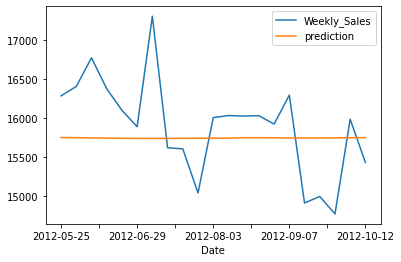

In [79]:
#LSTM (simple rnn과 동일한 optimizer)
def new_model_fun(X_train, y_train, X_test, sc):

    new_model=load_model('models/stock_model.h5')

    new_model.trainable=False
    
    # Compiling
    new_model.compile(optimizer='rmsprop', loss='mean_absolute_error')
    # Fitting to the training set
    new_model.fit(X_train,y_train,epochs=500, verbose=0)

    LSTM_prediction = new_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return new_model, LSTM_prediction

new_model_fun(X_train, y_train, X_test, sc)
pred_plot(LSTM_prediction)

#4-2) 수요예측 LSTM 모델에 적용 (재학습 1층)


(mae434.4138 mse: 345597.47)

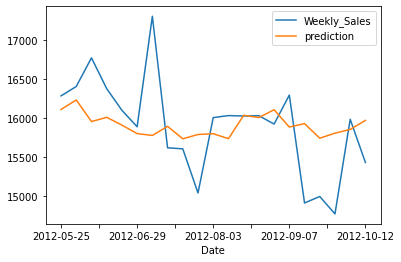

Epoch 1/500
4/4 [==============================] - 2s 8ms/step - loss: 1989.2534
Epoch 2/500
4/4 [==============================] - 0s 7ms/step - loss: 1844.8429
Epoch 3/500
4/4 [==============================] - 0s 8ms/step - loss: 1740.6450
Epoch 4/500
4/4 [==============================] - 0s 7ms/step - loss: 1615.2201
Epoch 5/500
4/4 [==============================] - 0s 7ms/step - loss: 1431.4686
Epoch 6/500
4/4 [==============================] - 0s 8ms/step - loss: 1173.1603
Epoch 7/500
4/4 [==============================] - 0s 8ms/step - loss: 811.7913
Epoch 8/500
4/4 [==============================] - 0s 7ms/step - loss: 330.3346
Epoch 9/500
4/4 [==============================] - 0s 7ms/step - loss: 22.9798
Epoch 10/500
4/4 [==============================] - 0s 7ms/step - loss: 15.9447
Epoch 11/500
4/4 [==============================] - 0s 8ms/step - loss: 15.6659
Epoch 12/500
4/4 [==============================] - 0s 8ms/step - loss: 15.4226
Epoch 13/500
4/4 [=================

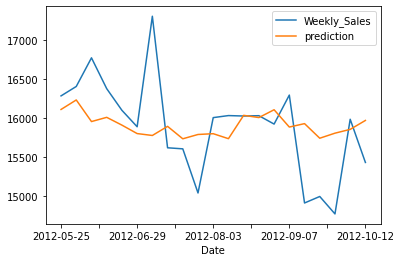

In [147]:
#LSTM에 적용 (마지막 레이어만 학습)

#LSTM (vanila rnn과 동일한 optimizer)
def new_LSTM_model(X_train, y_train, X_test, sc):

    new_model=load_model('models/stock_model.h5')
    # The LSTM architecture
    # my_LSTM_model = Sequential()
    # my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    # my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='relu'))
    # #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    # my_LSTM_model.add(LSTM(units=50, activation='tanh'))
    # my_LSTM_model.add(Dense(units=2))

    #my_LSTM_model.load_weights(stock_weight)

    for layer in new_model.layers[:-1]:
      layer.trainbale=False

    # Compiling
    new_model.compile(optimizer='rmsprop', loss='mean_absolute_error')
    # Fitting to the training set
    new_model.fit(X_train,y_train,epochs=500, verbose=1)

    LSTM_prediction = new_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return new_model, LSTM_prediction

new_model, LSTM_prediction= new_LSTM_model(X_train,y_train,X_test,sc)
pred_plot(LSTM_prediction)


# 4-2) 수요예측 LSTM 모델에 적용 (재학습 2층)

(mae: 616.5031 mse: 531686.75)

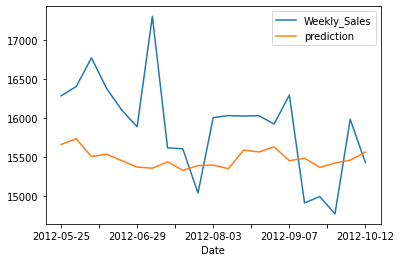

Epoch 1/500
4/4 [==============================] - 3s 8ms/step - loss: 1991.0728
Epoch 2/500
4/4 [==============================] - 0s 8ms/step - loss: 1847.0994
Epoch 3/500
4/4 [==============================] - 0s 7ms/step - loss: 1745.8749
Epoch 4/500
4/4 [==============================] - 0s 8ms/step - loss: 1630.9890
Epoch 5/500
4/4 [==============================] - 0s 8ms/step - loss: 1453.2988
Epoch 6/500
4/4 [==============================] - 0s 8ms/step - loss: 1208.1531
Epoch 7/500
4/4 [==============================] - 0s 8ms/step - loss: 869.8546
Epoch 8/500
4/4 [==============================] - 0s 7ms/step - loss: 425.8880
Epoch 9/500
4/4 [==============================] - 0s 7ms/step - loss: 40.1785
Epoch 10/500
4/4 [==============================] - 0s 7ms/step - loss: 15.7971
Epoch 11/500
4/4 [==============================] - 0s 7ms/step - loss: 15.5773
Epoch 12/500
4/4 [==============================] - 0s 7ms/step - loss: 15.4492
Epoch 13/500
4/4 [=================

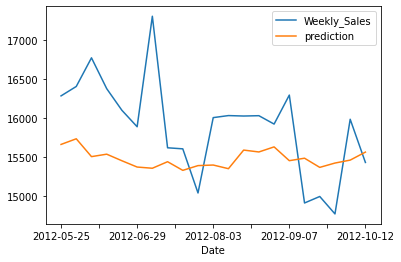

In [148]:
#LSTM BEST MODEL (마지막 2층 학습)

#LSTM (vanila rnn과 동일한 optimizer)
def LSTM_model(X_train, y_train, X_test, sc):

    new_model=load_model('models/stock_model.h5')


    for layer in new_model.layers[:-2]:
      layer.trainbale=False

    # Compiling
    new_model.compile(optimizer='rmsprop', loss='mean_absolute_error')
    # Fitting to the training set
    new_model.fit(X_train,y_train,epochs=500, verbose=1)

    LSTM_prediction = new_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction

my_LSTM_model, LSTM_prediction= LSTM_model(X_train,y_train,X_test,sc)
pred_plot(LSTM_prediction)

# 결론 및 한계점

* classic 머신러닝보다 RNN을 이용한 딥러닝이 시계열 데이터에서 예측 정확성이 높다 

* 동일한 모델(LSTM)에 대해 transfer learning 전 후 성능을 비교했을 때 ,transfer learning 후에 정확도가 향상 된다.

* 완벽하게 일치하지 않은 도메인이라도 ( market sales vs stock price) trnasfer learning이 정확도 향상에 어느정도  도움이 되는 것으로 보인다.

* transfer learning 시 재 학습 층의 개수와 정확도는 정비례 하지 않는다 ( 많은 층을 재학습한다고 정확도가 올라가진 않는다)

한계점 /후속 프로젝트

* 딥러닝의 경우 하이퍼 파라미터 튜닝을 하지 않았기 때문에, 현재 mae/mse 값이 모델 간의 성능 차이를 단언할 수 없다.

* multi variate(이전 time steps의 target값이 아닌 다른 변수를 X로), 특히 해당 데이터와 correaltion이 높은 feature를 사용해 예측을 진행해보고 싶다 

* 현실에서 접할 수 있는 정말 작은 데이터 ( 1년치이지만 4-5개 밖에 없는 데이터에서도 ) 예측이 가능할지 few shot learning을 적용해 보고 싶다. -전처리 데이터 준비완료 

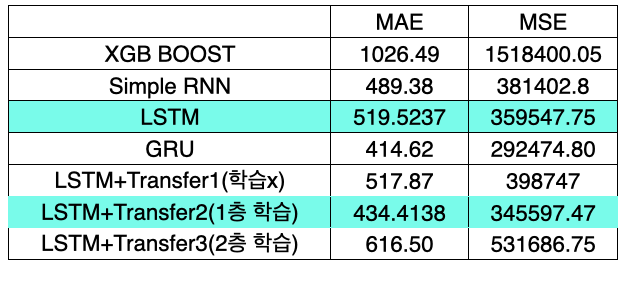